In [4]:
%cd "/workspace/src"

/workspace/src


In [5]:
from cvl.dataset import OnlineTrackingBenchmark
from cvl.trackers import MOSSETracker
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import norm
from cvl.image_io import crop_patch
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [224]:
dataset_path = "../data/Mini-OTB"
dataset = OnlineTrackingBenchmark(dataset_path)
SEQUENCE_IDX = 6
a_seq = iter(dataset[SEQUENCE_IDX])
first_frame = next(a_seq)

In [225]:
std = 20
learning_rate = 0.01
BBOX_ENLARGE_FACTOR = 1.0
tracker = MOSSETracker(std=std, learning_rate=learning_rate)

In [226]:
image = np.sum(first_frame["image"], 2) / 3
bbox = first_frame["bounding_box"]
bbox.__dict__

{'xpos': 6, 'ypos': 166, 'width': 42, 'height': 26}

In [227]:
bbox.xpos -= int(bbox.width * (BBOX_ENLARGE_FACTOR - 1) / 2)
bbox.width = int(bbox.width * BBOX_ENLARGE_FACTOR)
bbox.ypos -= int(bbox.height * (BBOX_ENLARGE_FACTOR - 1) / 2)
bbox.height = int(bbox.height * BBOX_ENLARGE_FACTOR)
if bbox.width % 2 == 0:
    bbox.width += 1

if bbox.height % 2 == 0:
    bbox.height += 1

In [228]:
bbox.__dict__

{'xpos': 6, 'ypos': 166, 'width': 43, 'height': 27}

## Start

In [229]:
# Where the gaussian should be centered
region = bbox
mean_x = region.width // 2
mean_y = region.height // 2

C = MOSSETracker.get_fft2_gaussian(height=region.height, width=region.width, std=std,
                                   mean_x=mean_x, mean_y=mean_y)

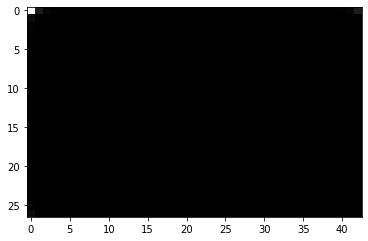

In [230]:
plt.imshow(np.abs(C), cmap="gray")

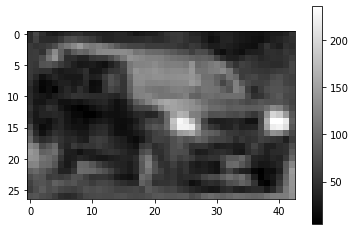

In [231]:
patch = crop_patch(image, region)
plt.imshow(patch, cmap="gray")
plt.colorbar()

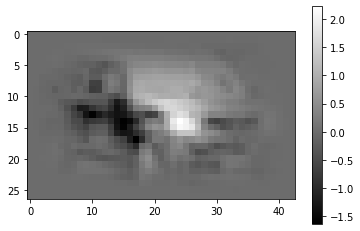

In [232]:
normalized_patch = MOSSETracker.normalize(patch)
plt.imshow(normalized_patch, cmap="gray")
plt.colorbar()

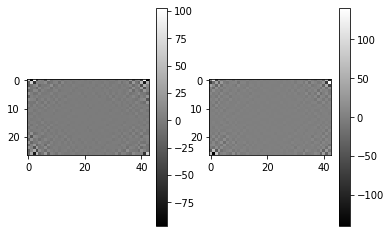

In [233]:
P = fft2(normalized_patch)
plt.subplot(121)
plt.imshow(np.real(P), cmap="gray")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.imag(P), cmap="gray")
plt.colorbar()

In [234]:
A = np.conjugate(C) * P
B = np.conjugate(P) * P

#aff_images = MOSSETracker.gen_affine_transform(patch, n_transforms=0)
#for aff_patch in aff_images:
#    P = fft2(MOSSETracker.normalize(patch))
#    self.A += C * np.conjugate(P)
#    self.B += np.conjugate(P) * P

M = A / B

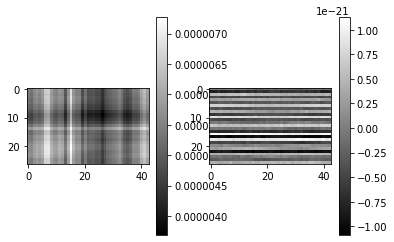

In [235]:
m = ifft2(M)
plt.subplot(121)
plt.imshow(np.real(m), cmap="gray")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.imag(m), cmap="gray")
plt.colorbar()

## Detect

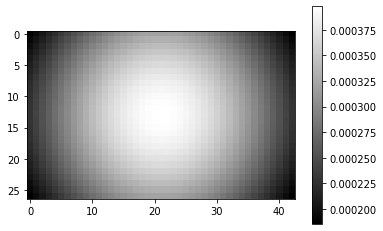

In [236]:
response = ifft2( np.conjugate(M) * P )
plt.imshow(np.real(response), cmap="gray")
plt.colorbar()

In [237]:
y, x = np.unravel_index(np.argmax(response), response.shape)

delta_x = x - region.width // 2
delta_y = y - region.height // 2
print(f"delta_x: {delta_x}\tdelta_y:{delta_y}")

delta_x: 0	delta_y:0


## Detect in next frame

Press CTRL+Enter to step through the frames

x: 21	y:13
delta_x: 0	delta_y:0


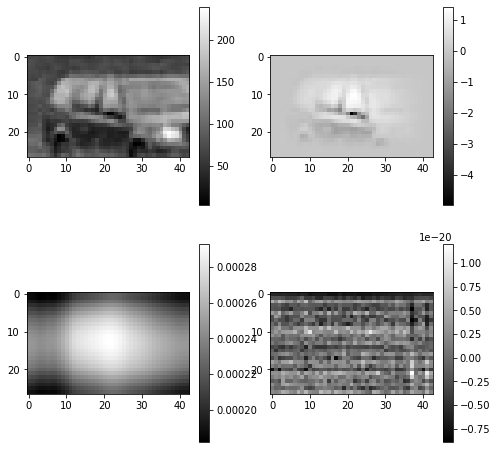

In [320]:
frame = next(a_seq)
image = np.sum(frame["image"], 2) / 3

plt.figure(figsize=(8, 8))

patch = crop_patch(image, region)
plt.subplot(221)
plt.imshow(patch, cmap="gray")
plt.colorbar()

normalized_patch = MOSSETracker.normalize(patch)
plt.subplot(222)
plt.imshow(normalized_patch, cmap="gray")
plt.colorbar()

P = fft2(normalized_patch)
response = ifft2( np.conjugate(M) * P )
plt.subplot(223)
plt.imshow(np.real(response), cmap="gray")
plt.colorbar()
plt.subplot(224)
plt.imshow(np.imag(response), cmap="gray")
plt.colorbar()

y, x = np.unravel_index(np.argmax(response), response.shape)

delta_x = x - region.width // 2
delta_y = y - region.height // 2
print(f"x: {x}\ty:{y}")
print(f"delta_x: {delta_x}\tdelta_y:{delta_y}")

region.xpos += delta_x
region.ypos += delta_y

A = A * (1-learning_rate) + np.conjugate(C) * P * learning_rate
B = B * (1-learning_rate) + np.conjugate(P) * P * learning_rate
M = A / B